<a target="_blank" href="https://colab.research.google.com/github/ArtificialIntelligenceToolkit/aitk/blob/master/notebooks/NeuralNetworks/AnalyzingHiddenRepresentations.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Analyzing Hidden Layer Representations

In this notebook we will train a simple network to recognize handwritten digits on a 6x6 grid. After training we will use both Principal Components Analysis (PCA) and Hierarchical Clustering to help visualize the hidden layer representations discovered by the network.

Let's begin by getting all of the necessary libraries.

In [1]:
%pip install aitk --quiet

In [2]:
import numpy as np
from aitk.utils import array_to_image, get_dataset, gallery

## Download the data

This data consists of 24 sets of handwritten digits (0-9) for a total of 240 examples. The inputs are provided on a 6x6 grid and the outputs are one-hot vectors.

In [3]:
inputs, targets = get_dataset("digits6x6")
inputs.shape

(240, 6, 6)

In [4]:
targets.shape

(240, 10)

Let's take a look at all of the images.

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111
112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143
144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159
160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175

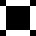
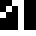
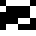
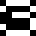
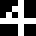
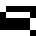
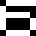
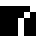
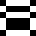
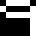
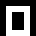
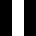
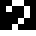
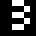
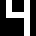
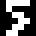
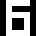
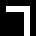
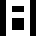
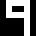
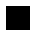
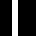
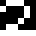
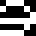
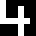
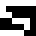
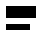
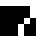
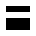
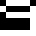
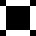
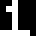
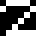
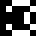
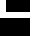
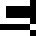
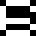
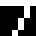
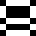
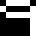
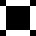
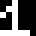
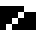
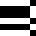
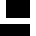
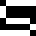
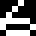
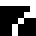
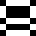
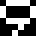
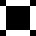
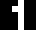
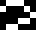
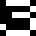
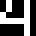
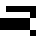
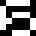
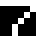
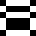
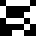
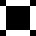
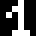
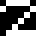
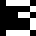
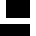
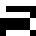
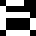
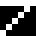
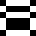
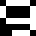
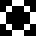
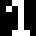
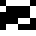
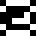
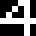
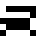
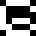
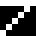
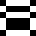
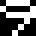
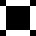
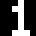
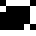
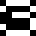
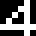
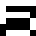
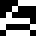
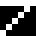
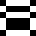
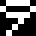
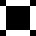
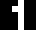
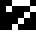
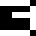
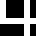
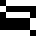
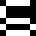
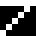
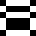
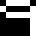
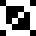
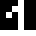
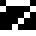
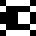
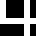
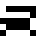
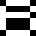
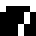
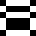
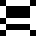
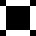
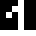
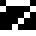
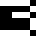
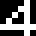
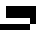
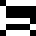
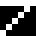
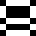
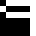
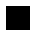
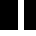
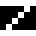
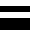
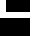
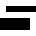
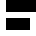
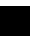
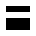
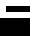
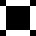
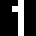
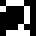
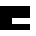
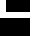
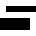
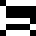
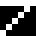
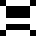
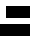
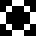
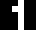
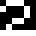
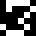
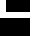
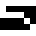
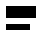
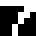
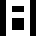
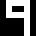
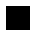
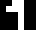
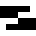
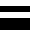
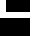
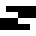
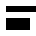
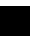
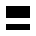
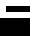
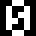
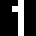
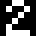
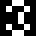
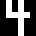
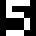
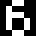
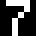
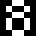
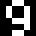
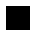
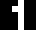
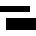
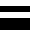
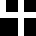
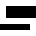
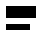
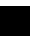
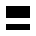
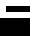
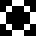
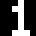
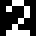
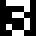
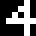
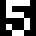
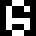
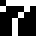
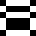
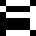
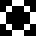
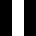
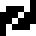
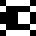
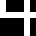
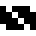
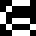
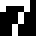
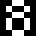
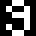
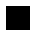
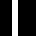
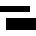
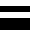
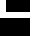
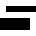
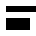
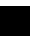
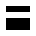
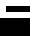
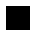
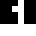
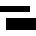
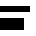
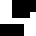
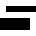
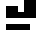
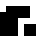
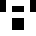
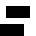
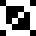
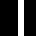
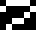
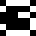
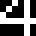
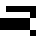
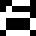
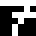
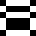
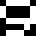
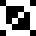
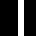
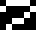
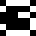
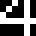
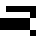
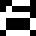
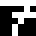
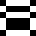
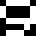

In [5]:
images = [array_to_image(inputs[i]) for i in range(len(inputs))]
bigger = [image.resize((36,36), resample=0) for image in images]
gallery(bigger)

## Build a Neural Network Model

Now we will construct a neural network to learn this data.

In [6]:
from aitk.networks import SimpleNetwork

In [7]:
def build_model():
    return SimpleNetwork(
        (6,6),
        "Flatten",
        (5, "sigmoid"),
        (10, "softmax"),
        loss = "categorical_crossentropy",
        metrics = ["tolerance_accuracy"]
    )

In [8]:
net = build_model()
net.set_tolerance(0.15)

In [9]:
net.summary()

Model: "SimpleNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 6, 6)]            0         
                                                                 
 flatten (Flatten)           (None, 36)                0         
                                                                 
 hidden_2 (Dense)            (None, 5)                 185       
                                                                 
 output (Dense)              (None, 10)                60        
                                                                 
Total params: 245 (980.00 Byte)
Trainable params: 245 (980.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Principal Components Analysis

We would like to understand more about how the network learns to categorize the images properly. One way to think about what a neural network is doing, is that each layer of weights is transforming the input into new representations that help the network distinguish between the desired categories.

Let's focus on the hidden layer, which transforms the 36 pixel values into a representation that is 5 long. Unfortunately we can't easily visualize 5 dimensions. However, PCA allows us to focus on just 2 dimensions where the most change is happening.


## Analyze hidden layer prior to training

Remember that each time we build a network model all of its weights will be initialized to small random values. If we test the network on all of the inputs, we can visualize the initial hidden layer representations **prior** to training, and compare them to the hidden layer representations discovered after training.

Let's give each digit a unique color encoding, pink represents 0's, red represents 1's, and so on (see encoding below).


In [10]:
# Give each digit it's own color
visualize = ["pink", "red", "orange", "yellow", "green",
           "teal", "blue", "indigo", "violet", "black"]
encoding = list(zip(range(10),visualize))
print(encoding)

[(0, 'pink'), (1, 'red'), (2, 'orange'), (3, 'yellow'), (4, 'green'), (5, 'teal'), (6, 'blue'), (7, 'indigo'), (8, 'violet'), (9, 'black')]


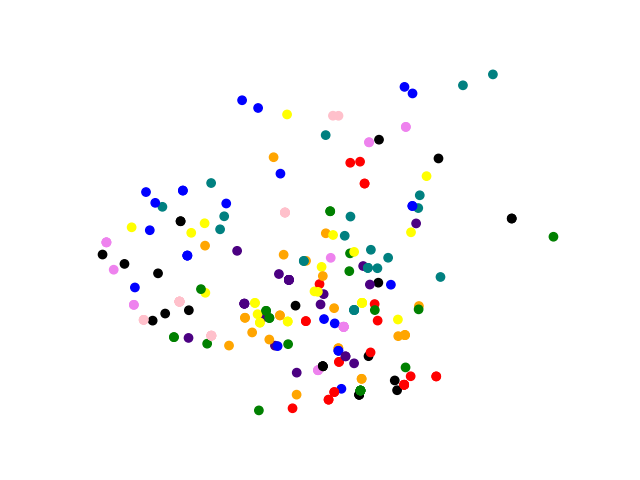

In [11]:
net.set_pca_spaces(inputs)
net.predict_pca_to(inputs, 'hidden_2', visualize*24, None)

Notice in the graph above that all of the colors are jumbled and intermixed. The network has not yet been trained so all of its weights are still random. Let's train the network, and redo this analysis and see how the hidden layer representations change.

## Train the network

In [12]:
history = net.fit(
    inputs, targets,
    batch_size=16,
    shuffle=True,
    epochs=300,
    accuracy=1.0,
    patience=30,
    report_rate=10,
)

Epoch 300/300 loss: 0.008977795019745827 - tolerance_accuracy: 0.9958333373069763


## Test the Trained Network

We can test how well the network has learned the data by propagating some of the input patterns through the trained network.

In [13]:
from time import sleep
for pattern in inputs[0:10]:
    net.display(pattern)
    sleep(1.0)

## Analyze hidden layer after training

Let's look at how the hidden layer representations have changed **after** training. Compare the graph below to the one above. Now clear patterns are emerging. You should see lots of clusters of similar colors indicating that the network has created hidden representations to help it correctly categorize each type of digit.

In [14]:
print(encoding)

[(0, 'pink'), (1, 'red'), (2, 'orange'), (3, 'yellow'), (4, 'green'), (5, 'teal'), (6, 'blue'), (7, 'indigo'), (8, 'violet'), (9, 'black')]


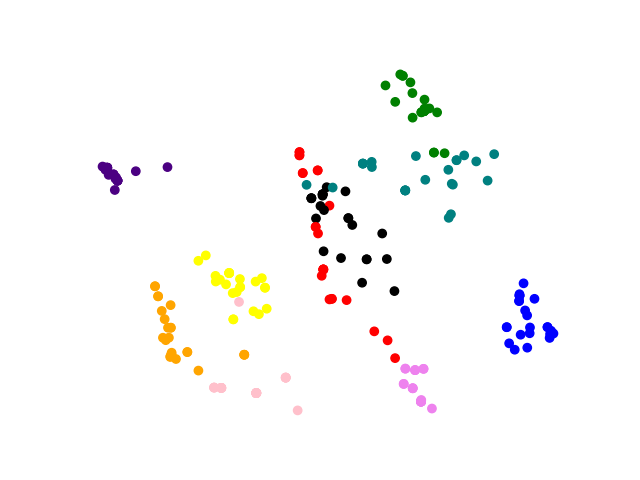

In [15]:
net.set_pca_spaces(inputs)
net.predict_pca_to(inputs, 'hidden_2', visualize*24, None)

Each run of the network will likely be slightly different, but notice that after training, the hidden layer representations for each digit are now more clustered together, rather than being all jumbled as before. Remember that each color represents training examples for one particular digit (e.g. blue is for the digit 6).

Some of the clusters you see are likely more compact than others. Several of the clusters may even be intermingled with one another. Use the color key to try to figure out which digits hidden layer representations are intermingled. Then draw them on top of one another. Do they share some of the same substructure?

## Cluster Analysis

Another way to analyze the hidden layer representation is to do a cluster analysis. Here we consider every hidden layer representation and calculate the Euclidean distance between every possible pair. The two closest examples form a cluster and their average is put back into the set of representations. We continue this process until a complete tree has been formed.

In [16]:
from scipy.cluster import hierarchy
%matplotlib inline

In [17]:
labelList = [str(v) for v in range(10)]

In [18]:
hidden_raw = net.predict_to(inputs, "hidden_2")

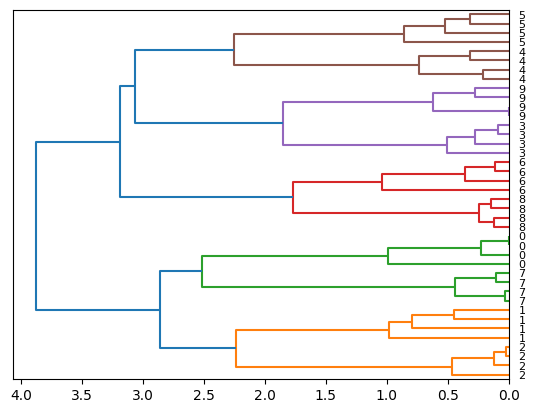

In [19]:
result = hierarchy.dendrogram(
    hierarchy.linkage(hidden_raw[0:40],method='ward'),
    orientation="left",
    labels=labelList*4,
)

Notice that the neural network will typically discover hidden layer representations such that all digits of the same type are closer to one another than to other digits.

## Conclusion

The way a neural network processes data is to transform the data through its hidden layers. Through this notebook, we have visualized how the hidden layer representations changed as a result of training the network.